<a href="https://colab.research.google.com/github/slvDev/Malaria-Detection-CNN-Keras/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import os
import cv2
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from random import randrange
from shutil import move, rmtree

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
zip_ref_train = zipfile.ZipFile('/content/drive/My Drive/cell-images-for-detecting-malaria.zip', 'r')
zip_ref_train.extractall('/content')
zip_ref_train.close()

In [0]:
ROOT_DATA_DIR = '/content/cell_images'
INF_DIR = os.path.join(ROOT_DATA_DIR, 'Parasitized')
UNINF_DIR = os.path.join(ROOT_DATA_DIR, 'Uninfected')

inf_fnames = os.listdir(INF_DIR)
uninf_fnames = os.listdir(UNINF_DIR)

print(f'Amount of parasitized images: {len(inf_fnames)}')
print(f'Amount of uninfected images: {len(uninf_fnames)}')
print(f'Total Images: {len(inf_fnames) + len(uninf_fnames)}')

Amount of parasitized images: 11024
Amount of uninfected images: 11024
Total Images: 22048


In [0]:
rmtree('/content/valid_test_cell_images')

In [0]:
def split_data(sourse, split_size):
    #Create root folder for valid&test data
    root_folder_name = ROOT_DATA_DIR.strip('/').split('/')[-1]
    valid_test_folder = ROOT_DATA_DIR.replace(root_folder_name,
                                            'valid_test_' + root_folder_name)
    
    os.mkdir(valid_test_folder)
    
    folders = os.listdir(sourse)
    for folder in folders:
        os.mkdir(os.path.join(valid_test_folder, folder))
        fnames = os.listdir(os.path.join(sourse, folder))
        start_split = len(fnames) - int(len(fnames) * split_size)
        splited_fnames = fnames[start_split:]
        for fname in splited_fnames:
            s_dir = os.path.join(sourse, folder, fname)
            d_dir = os.path.join(valid_test_folder, folder, fname)
            move(s_dir, d_dir)
        print(f'Moved {len(splited_fnames)} files')


In [0]:
split_data(ROOT_DATA_DIR, 0.2)

Moved 2756 files
Moved 2756 files


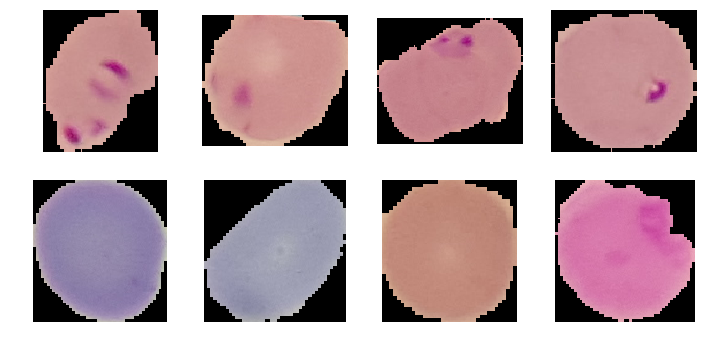

In [0]:
nrows, ncols = 4, 4
fig_size = 3 

fig = plt.gcf()
fig.set_size_inches(ncols * fig_size, nrows * fig_size)

inf_pic_paths = [os.path.join(INF_DIR, inf_fnames[randrange(len(inf_fnames))]) 
                for _ in range(4) 
                ]

uninf_pic_paths = [os.path.join(UNINF_DIR, uninf_fnames[randrange(len(uninf_fnames))]) 
                for _ in range(4) 
                ]

for i, img_path in enumerate(inf_pic_paths + uninf_pic_paths):  
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

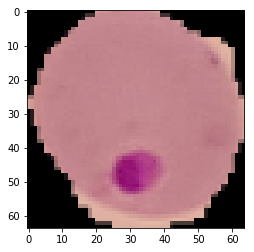

In [60]:
img_size = 64
dim = img_size, img_size

img_path = os.path.join(INF_DIR, inf_fnames[1])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dim)

plt.imshow(img)
plt.show()

In [61]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        )

train_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        )

Found 22046 images belonging to 2 classes.


In [62]:
valid_test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
        )

valid_generator = valid_test_datagen.flow_from_directory(
        '/content/valid_test_cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='training',
        )

test_generator = valid_test_datagen.flow_from_directory(
        '/content/valid_test_cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='validation',
        )

Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model.summary()

In [64]:
history = model.fit_generator(
        train_generator,
        epochs=50,
        validation_data=valid_generator,
        )

Epoch 1/50
689/689 [==============================] - 66s 95ms/step - loss: 0.3066 - acc: 0.8901 - val_loss: 0.2232 - val_acc: 0.9380
Epoch 2/50
689/689 [==============================] - 64s 93ms/step - loss: 0.1743 - acc: 0.9427 - val_loss: 0.1478 - val_acc: 0.9590
Epoch 3/50
689/689 [==============================] - 64s 93ms/step - loss: 0.1644 - acc: 0.9462 - val_loss: 0.1227 - val_acc: 0.9590
Epoch 4/50
689/689 [==============================] - 64s 93ms/step - loss: 0.1572 - acc: 0.9490 - val_loss: 0.1211 - val_acc: 0.9579
Epoch 5/50
689/689 [==============================] - 65s 94ms/step - loss: 0.1534 - acc: 0.9498 - val_loss: 0.1255 - val_acc: 0.9586
Epoch 6/50
689/689 [==============================] - 65s 94ms/step - loss: 0.1542 - acc: 0.9512 - val_loss: 0.1154 - val_acc: 0.9612
Epoch 7/50
689/689 [==============================] - 65s 94ms/step - loss: 0.1502 - acc: 0.9520 - val_loss: 0.1173 - val_acc: 0.9615
Epoch 8/50
689/689 [==============================] - 65s 94ms

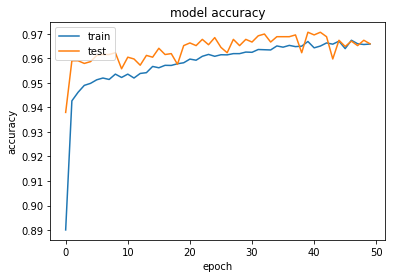

In [65]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

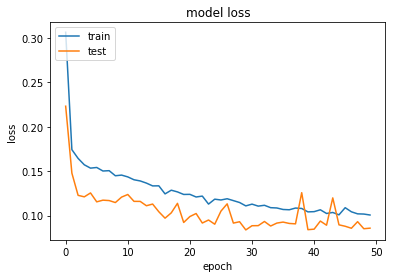

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
model.evaluate_generator(test_generator, verbose=1)

87/87 [==============================] - 3s 38ms/step - loss: 0.0961 - acc: 0.9666


[0.09614790938045273, 0.9666183]